чтоб запустить нижеприведенный код выполните следующие команды:<br>
    conda install -c conda-forge folium<br>
    conda install -c conda-forge basemap

In [1]:
%pylab inline
import pandas as pd
from scipy import stats

import os
import folium
from folium.plugins import HeatMap

from matplotlib.cm import ScalarMappable
from matplotlib.colors import  rgb2hex,Normalize, LogNorm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


Loading data about yellow taxi and about regions

1. Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [2]:
tripdata = pd.read_csv("yellow_tripdata_2016-05.csv",",", 
                       parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
regions = pd.read_csv("regions.csv",";")

In [3]:
LonFrom = -74.25559
LonTo = -73.70001
LatFrom = 40.49612
LatTo = 40.91553
tripdata = tripdata[(tripdata['trip_distance'] != 0) & 
          (tripdata['passenger_count'] != 0) &
          (tripdata['tpep_pickup_datetime'] != tripdata['tpep_dropoff_datetime']) &
          (tripdata['pickup_longitude'] > LonFrom) &
          (tripdata['pickup_longitude'] < LonTo) &
          (tripdata['pickup_latitude'] > LatFrom) &
          (tripdata['pickup_latitude'] < LatTo)]

def getRegion (longitude, latitude):
    binsX = np.linspace(LonFrom, LonTo, 51)
    binsY = np.linspace(LatFrom, LatTo, 51)
    reg = stats.binned_statistic_2d(longitude, latitude, None, 
                                              statistic = "count", bins = [binsX, binsY], expand_binnumbers=True)
    return (reg.binnumber[0] - 1) * 50 + reg.binnumber[1]

tripdata['region'] = getRegion(tripdata.pickup_longitude, tripdata.pickup_latitude)


2. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [4]:
regions_range = np.arange(1, 2501)
all_regions = pd.DataFrame()
all_regions["region"] = regions_range
all_regions["counts"] = 0

region_notzero = tripdata["region"].value_counts()
region_notzero = (region_notzero).to_frame()
region_notzero.columns = ['counts']
region_notzero.index.name = 'region'
region_notzero = region_notzero.sort_values(by=['region'])
region_notzero.reset_index(level=0, inplace=True)

regions_all_data = pd.merge_asof(all_regions, region_notzero, on='region', by = ['region'])

regions_all_data = regions_all_data.fillna(0)
regions_all_data = regions_all_data.drop(["counts_x"], axis = 1)
regions_all_data = regions_all_data.rename(columns={'counts_y': 'counts'})

len(regions_all_data[regions_all_data["counts"] == 0])

1283

2. Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.
3. Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

In [5]:
# Тут я выцисляю координаты центров регионов и добавляю их координаты к датафрейму. 
# Также я добавляю колонку показывающую среднее кол-во поездок в час (в мае 744 часа)

region_lon_length = (regions.iloc[0]["east"] - regions.iloc[0]["west"])/2
region_lat_length = (regions.iloc[0]["north"] - regions.iloc[0]["south"])/2
regions_all_data["lon_center"] = regions["west"] + region_lon_length
regions_all_data["lat_center"] = regions["south"] + region_lat_length
regions_all_data["average_per_hour"] = regions_all_data["counts"]/744

regions_all_data["south"] = regions["south"]
regions_all_data["north"] = regions["north"]
regions_all_data["west"] = regions["west"]
regions_all_data["east"] = regions["east"]

regions_all_data.head()

region  counts  lon_center  lat_center  average_per_hour      south  \
0       1     0.0  -74.250034   40.500314               0.0  40.496120   
1       2     0.0  -74.250034   40.508702               0.0  40.504508   
2       3     0.0  -74.250034   40.517090               0.0  40.512896   
3       4     0.0  -74.250034   40.525479               0.0  40.521285   
4       5     0.0  -74.250034   40.533867               0.0  40.529673   

       north      west       east  
0  40.504508 -74.25559 -74.244478  
1  40.512896 -74.25559 -74.244478  
2  40.521285 -74.25559 -74.244478  
3  40.529673 -74.25559 -74.244478  
4  40.538061 -74.25559 -74.244478

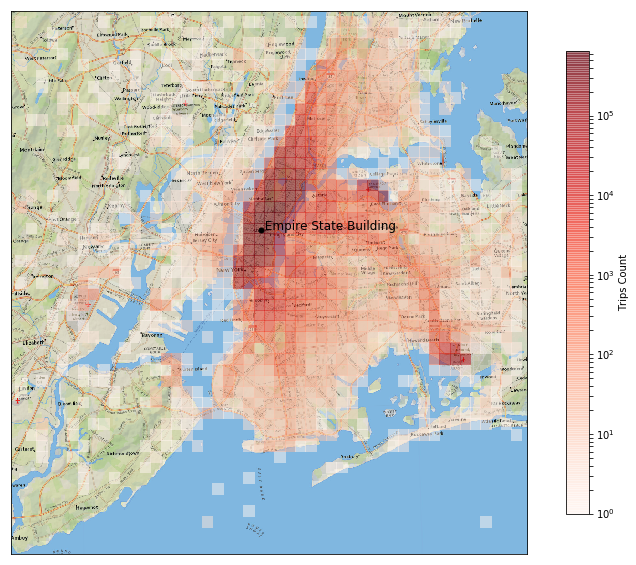

In [45]:
fig = plt.figure(figsize=(14,10))

m1 = Basemap(projection='merc', llcrnrlat=LatFrom, urcrnrlat=LatTo,
            llcrnrlon=LonFrom, urcrnrlon=LonTo, lat_ts=LatFrom, resolution='f', area_thresh = 0.1, epsg=2261)

m1.arcgisimage(service='NatGeo_World_Map', xpixels = 1000)

esb_lon, esb_lat = m1(-73.985477, 40.748364)
plt.plot(esb_lon, esb_lat, 'ok', markersize=5)
plt.text(esb_lon, esb_lat, ' Empire State Building', fontsize=12);


m1.pcolormesh(regions_all_data.lon_center.unique(), regions_all_data.lat_center.unique(),
                regions_all_data.counts.values.reshape(50,50).T,
                norm=LogNorm(vmin=1, vmax=np.max(regions_all_data.counts)),
                latlon=True, cmap='Reds', alpha = 0.5)

# ----- Below is alternative way to the colormesh above, and it also works, but more code ---    
#lon_bins = np.linspace(LonFrom, LonTo, 51)
#lat_bins = np.linspace(LatFrom, LatTo, 51)
#density, _, _ = np.histogram2d(tripdata.pickup_latitude.values, tripdata.pickup_longitude.values, 
#                    [lat_bins, lon_bins])
#lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)
#xs, ys = m1(lon_bins_2d, lat_bins_2d)
#m1.pcolormesh(xs, ys, density, norm=LogNorm(vmin=1, vmax=np.max(regions_all_data.counts)), cmap="Reds", alpha = 0.5)



plt.colorbar(orientation='vertical', shrink=0.85, label='Trips Count')
plt.show()  

4. Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

In [8]:
m = folium.Map([40.63612, -74.00559], tiles='Stamen Toner', zoom_start=11)
folium.Marker([40.689347, -74.044704], popup='<i>Statue of Liberty</i>', tooltip="Click me").add_to(m)
m

5. Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

Решение 1:

In [9]:
data = zip(regions_all_data["lat_center"], regions_all_data["lon_center"], regions_all_data["average_per_hour"])
m1 = folium.Map([40.73612, -74.00559], tiles='Stamen Toner', zoom_start=10)
HeatMap(data).add_to(m1)
m1

Решение 2:

In [53]:
m3 = folium.Map([40.73612, -74.00559], tiles='Stamen Toner', zoom_start=10)

vals = regions_all_data["average_per_hour"].values.reshape(50,50).T
log_norm = LogNorm(vmin=0.01, vmax=np.max(vals))
mapper = ScalarMappable(norm=log_norm, cmap='Reds')

for ind_lat, lat in enumerate(regions_all_data.south.unique()[:-1]):
    for ind_lon, lon in enumerate(regions_all_data.west.unique()[:-1]):
        color = rgb2hex(mapper.to_rgba(vals[ind_lat][ind_lon])[:3])
        folium.Rectangle(bounds=((lat, lon), 
                        (regions_all_data.south.unique()[ind_lat+1], regions_all_data.west.unique()[ind_lon+1])),
                         color=color,
                         opacity=0.3,
                         weight=1,
                         fill_opacity=0.5,
                         fill_color=color).add_to(m3)
m3

6. Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [11]:
regions_more_than_5 = regions_all_data[regions_all_data["average_per_hour"] > 5]
len(regions_more_than_5)

102

Решение 1:

In [12]:
data1 = zip(regions_more_than_5["lat_center"], regions_more_than_5["lon_center"], 
                                                    regions_more_than_5["average_per_hour"])
m2 = folium.Map([40.73612, -74.00559], tiles='Stamen Toner', zoom_start=10.5)
HeatMap(data1).add_to(m2)
m2

Решение 2:

In [13]:
regions_all_data["count_more_than_5"] = regions_all_data["average_per_hour"].apply(lambda x: x*(x>=5))
m4 = folium.Map([40.73612, -74.00559], tiles='Stamen Toner', zoom_start=10)

vals = regions_all_data["count_more_than_5"].values.reshape(50,50).T
log_norm = LogNorm(vmin=0.01, vmax=np.max(vals))
mapper = ScalarMappable(norm=log_norm, cmap='Reds')

for ind_lat, lat in enumerate(regions_all_data.south.unique()[:-1]):
    for ind_lon, lon in enumerate(regions_all_data.west.unique()[:-1]):
        color = rgb2hex(mapper.to_rgba(vals[ind_lat][ind_lon])[:3])
        folium.Rectangle(bounds=((lat, lon), 
                                (regions_all_data.south.unique()[ind_lat+1], 
                                 regions_all_data.west.unique()[ind_lon+1])),
                         color=color,
                         opacity=0.3,
                         weight=1,
                         fill_opacity=0.5,
                         fill_color=color).add_to(m4)
m4